### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import holidays
import time

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


from xgboost import XGBRegressor, XGBRFRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

### Load data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

In [3]:
# preview data
train.head()

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


In [4]:
test.head()

,date,hour
0,2021-03-01,0
1,2021-03-01,1
2,2021-03-01,2
3,2021-03-01,3
4,2021-03-01,5


In [5]:
submission.head()

,date,hour,demand
0,2021-03-01,0,0
1,2021-03-01,1,0
2,2021-03-01,2,0
3,2021-03-01,3,0
4,2021-03-01,5,0


In [6]:
# date formatting
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [7]:
train.sort_values(['date', 'hour']).head()

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


In [8]:
train['date'].unique()[:5]

array(['2018-08-18T00:00:00.000000000', '2018-08-19T00:00:00.000000000',
       '2018-08-20T00:00:00.000000000', '2018-08-21T00:00:00.000000000',
       '2018-08-22T00:00:00.000000000'], dtype='datetime64[ns]')

Date values are continuous, but the hour level data is not continous. So, we cannot apply regular time series forecasting models like ARIMA, SARIMA etc.,


C:\anaconda_installed\envs\AlgoTrading\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='date', ylabel='demand'>

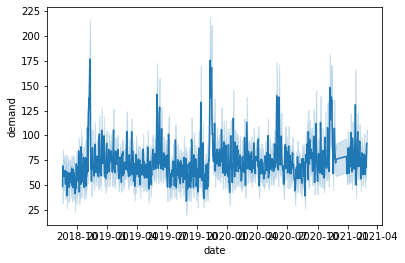

In [9]:
# date v/s demand distribution
sns.lineplot(train['date'], train['demand'])

### Feature Engineering

In [10]:
# check null values
train.isnull().sum()

date      0
hour      0
demand    0
dtype: int64

In [11]:
test.isnull().sum()

date    0
hour    0
dtype: int64

In [12]:
def checkWeekend(x):
    if x=='Saturday' or x=='Sunday':
        return 1
    return 0        

#### Create attributes from date column

In [13]:
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['weekofyear'] = train['date'].dt.isocalendar().week
train['day_of_week'] = train['date'].dt.dayofweek
train['is_weekend'] = train['day_of_week'].apply(lambda x: 1 if x>4 else 0)

# pre/post weekend may have impact on car demand
train['post_weekend'] = (train['day_of_week']==1).astype(int)
train['pre_weekend'] = (train['day_of_week']==4).astype(int)
train['quarter'] = train['date'].dt.quarter

In [14]:
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['weekofyear'] = test['date'].dt.isocalendar().week
test['day_of_week'] = test['date'].dt.dayofweek
test['is_weekend'] = test['day_of_week'].apply(lambda x: 1 if x>4 else 0)

# pre/post weekend may have impact on car demand
test['post_weekend'] = (test['day_of_week']==1).astype(int)
test['pre_weekend'] = (test['day_of_week']==4).astype(int)
test['quarter'] = test['date'].dt.quarter

In [15]:
train.head()

,date,hour,demand,month,day,weekofyear,day_of_week,is_weekend,post_weekend,pre_weekend,quarter
0,2018-08-18,9,91,8,18,33,5,1,0,0,3
1,2018-08-18,10,21,8,18,33,5,1,0,0,3
2,2018-08-18,13,23,8,18,33,5,1,0,0,3
3,2018-08-18,14,104,8,18,33,5,1,0,0,3
4,2018-08-18,15,81,8,18,33,5,1,0,0,3


#### Add holidays data

In [16]:
train['date'].dt.year.unique(), test['date'].dt.year.unique()

(array([2018, 2019, 2020, 2021], dtype=int64),
 array([2021, 2022], dtype=int64))

In [17]:
# get Karnataka holidays for the required years
karnataka_holidays = holidays.IN(subdiv='KA', years=[2018,2019,2020,2021,2022])

In [18]:
karnataka_holidays

{datetime.date(2018, 1, 14): 'Makar Sankranti / Pongal', datetime.date(2018, 1, 26): 'Republic Day', datetime.date(2018, 8, 15): 'Independence Day', datetime.date(2018, 10, 2): 'Gandhi Jayanti', datetime.date(2018, 5, 1): 'Labour Day', datetime.date(2018, 12, 25): 'Christmas', datetime.date(2018, 11, 1): 'Karnataka Rajyotsava', datetime.date(2018, 11, 7): 'Diwali', datetime.date(2018, 3, 2): 'Holi', datetime.date(2019, 1, 14): 'Makar Sankranti / Pongal', datetime.date(2019, 1, 26): 'Republic Day', datetime.date(2019, 8, 15): 'Independence Day', datetime.date(2019, 10, 2): 'Gandhi Jayanti', datetime.date(2019, 5, 1): 'Labour Day', datetime.date(2019, 12, 25): 'Christmas', datetime.date(2019, 11, 1): 'Karnataka Rajyotsava', datetime.date(2019, 10, 27): 'Diwali', datetime.date(2019, 3, 21): 'Holi', datetime.date(2020, 1, 14): 'Makar Sankranti / Pongal', datetime.date(2020, 1, 26): 'Republic Day', datetime.date(2020, 8, 15): 'Independence Day', datetime.date(2020, 10, 2): 'Gandhi Jayanti',

In [19]:
# create holiday column from holidays data
train['is_govt_holiday'] = train['date'].isin(karnataka_holidays).astype(int)
test['is_govt_holiday'] = test['date'].isin(karnataka_holidays).astype(int)

In [20]:
train

,date,hour,demand,month,day,weekofyear,day_of_week,is_weekend,post_weekend,pre_weekend,quarter,is_govt_holiday
0,2018-08-18,9,91,8,18,33,5,1,0,0,3,0
1,2018-08-18,10,21,8,18,33,5,1,0,0,3,0
2,2018-08-18,13,23,8,18,33,5,1,0,0,3,0
3,2018-08-18,14,104,8,18,33,5,1,0,0,3,0
4,2018-08-18,15,81,8,18,33,5,1,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18242,2021-02-28,19,95,2,28,8,6,1,0,0,1,0
18243,2021-02-28,20,88,2,28,8,6,1,0,0,1,0
18244,2021-02-28,21,39,2,28,8,6,1,0,0,1,0
18245,2021-02-28,22,104,2,28,8,6,1,0,0,1,0


In [21]:
test

,date,hour,month,day,weekofyear,day_of_week,is_weekend,post_weekend,pre_weekend,quarter,is_govt_holiday
0,2021-03-01,0,3,1,9,0,0,0,0,1,0
1,2021-03-01,1,3,1,9,0,0,0,0,1,0
2,2021-03-01,2,3,1,9,0,0,0,0,1,0
3,2021-03-01,3,3,1,9,0,0,0,0,1,0
4,2021-03-01,5,3,1,9,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
7645,2022-03-28,19,3,28,13,0,0,0,0,1,0
7646,2022-03-28,20,3,28,13,0,0,0,0,1,0
7647,2022-03-28,21,3,28,13,0,0,0,0,1,0
7648,2022-03-28,22,3,28,13,0,0,0,0,1,0


### Exploratory Data Analysis

#### hour 

In [22]:
train['hour'].describe()

count    18247.000000
mean        12.614731
std          6.544963
min          0.000000
25%          8.000000
50%         13.000000
75%         18.000000
max         23.000000
Name: hour, dtype: float64

Text(0.5, 1.0, 'Test - hour')

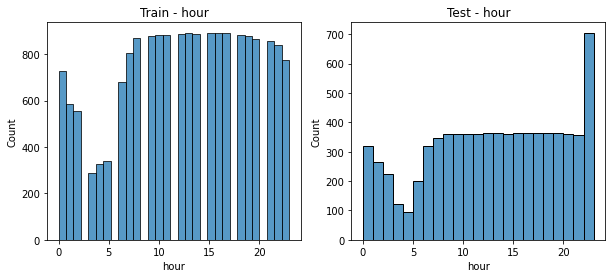

In [23]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.histplot(train['hour'])
plt.title('Train - hour')
plt.subplot(122)
sns.histplot(test['hour'])
plt.title('Test - hour')

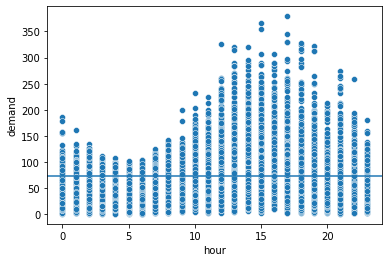

In [24]:
g = sns.scatterplot(x='hour', y='demand', data=train)
plt.axhline(train['demand'].mean())

different hour slots has varying car demand. we can confirm that hour has an impact on car demand

In [25]:
#creating function to identify time of day: morning, afternoon, evening, night, etc.
def get_time_slot(hour):
    if hour in range(4,8):
        return 'Early Morning'
    elif hour in range(8,12):
        return 'Morning'
    elif hour in range(12,18):
        return 'Afternoon'
    elif hour in range(18,21):
        return 'Evening'
    elif hour in range(21,25) or hour==0:
        return 'Night'
    elif hour in range(1,4):
        return 'Late Night'

In [26]:
train['timeSlot'] = train['hour'].apply(get_time_slot)
test['timeSlot'] = test['hour'].apply(get_time_slot)

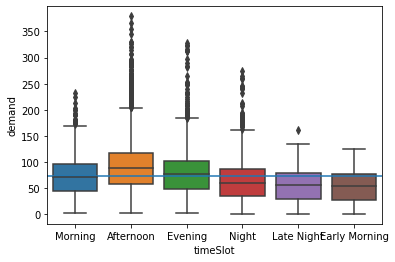

In [27]:
sns.boxplot(x='timeSlot', y='demand', data=train)#, order=['dawn', 'morning', 'noon', 'afternoon', 'evening', 'midnight'])
plt.axhline(train['demand'].mean())

Morning, Afternoon and evening time slots has highest demand for cars

### month

Text(0.5, 1.0, 'Test - month')

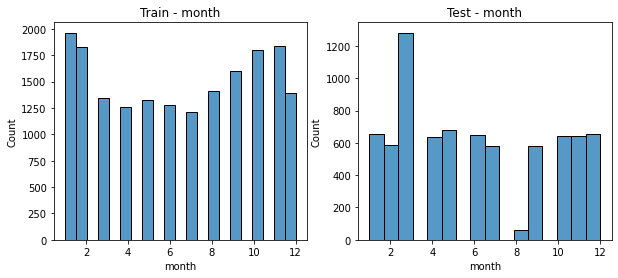

In [28]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.histplot(train['month'])
plt.title('Train - month')
plt.subplot(122)
sns.histplot(test['month'])
plt.title('Test - month')

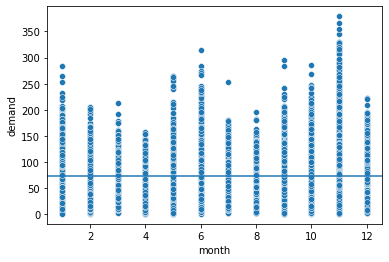

In [29]:
g = sns.scatterplot(x='month', y='demand', data=train)
plt.axhline(train['demand'].mean())

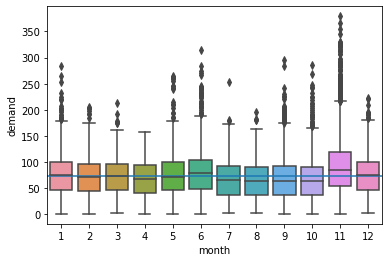

In [30]:
g = sns.boxplot(x='month', y='demand', data=train)
plt.axhline(train['demand'].mean())

month 6 and 11 has higher median compared to other months

In [31]:
train['Highest_demand_months'] = train['month'].isin([6,11]).astype(int)
test['Highest_demand_months'] = test['month'].isin([6,11]).astype(int)

### day

Text(0.5, 1.0, 'Test - day')

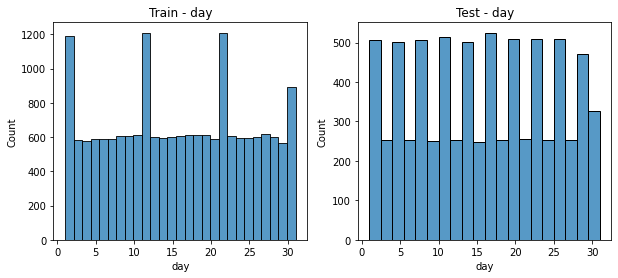

In [32]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.histplot(train['day'])
plt.title('Train - day')
plt.subplot(122)
sns.histplot(test['day'])
plt.title('Test - day')

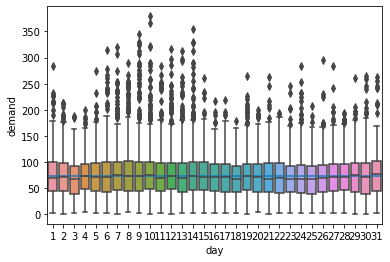

In [33]:
sns.boxplot(x='day', y='demand', data=train)
plt.axhline(train['demand'].mean())

### day_of_week

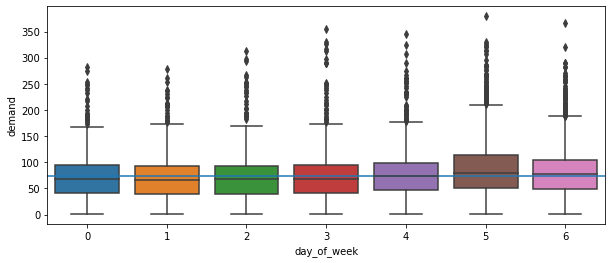

In [34]:
plt.figure(figsize=(10,4))
sns.boxplot(x='day_of_week', y='demand', data=train)
plt.axhline(train['demand'].mean())

weekend has highest demand for cars 

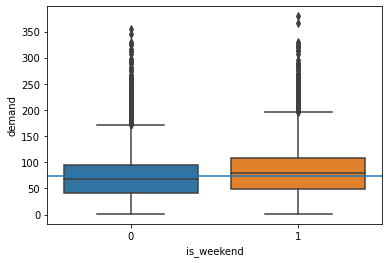

In [35]:
sns.boxplot(x='is_weekend', y='demand', data=train)
plt.axhline(train['demand'].mean())

### quarter

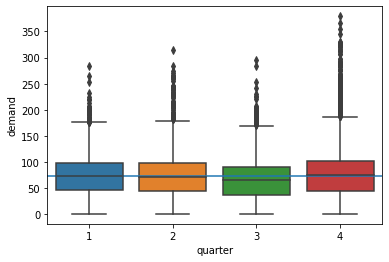

In [36]:
sns.boxplot(x='quarter', y='demand', data=train)
plt.axhline(train['demand'].mean())

In [37]:
# creating function to convert month to seasons
def get_season(month):
    if month in [9, 10, 11]:
        season = 'Spring'
    elif month in [12, 1, 2]:
        season = 'Summer'
    elif month in [3, 4, 5]:
        season = 'Autumn'
    elif month in [6, 7, 8]:
        season = 'Winter'
    return season

In [38]:
train['season'] = train['month'].apply(get_season)
test['season'] = test['month'].apply(get_season)

In [39]:
# encode the categorical features timeSlot & season
train['timeSlot'].replace({'Afternoon': 0, 'Morning' : 1, 'Night':2, 'Evening':3, 'Early Morning':4, 'Late Night':5}, 
                          inplace=True)
train['season'].replace({'Spring':0, 'Summer':1, 'Autumn':2, 'Winter':3}, inplace=True)

In [40]:
# encode the categorical features timeSlot & season
test['timeSlot'].replace({'Afternoon': 0, 'Morning' : 1, 'Night':2, 'Evening':3, 'Early Morning':4, 'Late Night':5}, 
                          inplace=True)
test['season'].replace({'Spring':0, 'Summer':1, 'Autumn':2, 'Winter':3}, inplace=True)

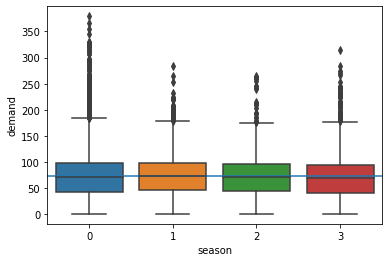

In [41]:
sns.boxplot(x='season', y='demand', data=train)
plt.axhline(train['demand'].mean())

#### Cyclic features

In [42]:
def encode_cyclic_feature(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [43]:
# Feature engineering of hour of month like cyclical feature & days in week feature
train = encode_cyclic_feature(train, 'hour', 24)
train = encode_cyclic_feature(train, 'month', 12)
train = encode_cyclic_feature(train, 'day_of_week', 7)

test = encode_cyclic_feature(test, 'hour', 24)
test = encode_cyclic_feature(test, 'month', 12)
test = encode_cyclic_feature(test, 'day_of_week', 7)

In [44]:
train.head()

,date,hour,demand,month,day,weekofyear,day_of_week,is_weekend,post_weekend,pre_weekend,...,is_govt_holiday,timeSlot,Highest_demand_months,season,hour_sin,hour_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos
0,2018-08-18,9,91,8,18,33,5,1,0,0,...,0,1,0,3,0.707107,-0.707107,-0.866025,-0.5,-0.974928,-0.222521
1,2018-08-18,10,21,8,18,33,5,1,0,0,...,0,1,0,3,0.500000,-0.866025,-0.866025,-0.5,-0.974928,-0.222521
2,2018-08-18,13,23,8,18,33,5,1,0,0,...,0,0,0,3,-0.258819,-0.965926,-0.866025,-0.5,-0.974928,-0.222521
3,2018-08-18,14,104,8,18,33,5,1,0,0,...,0,0,0,3,-0.500000,-0.866025,-0.866025,-0.5,-0.974928,-0.222521
4,2018-08-18,15,81,8,18,33,5,1,0,0,...,0,0,0,3,-0.707107,-0.707107,-0.866025,-0.5,-0.974928,-0.222521


In [45]:
X = train.drop(['date', 'demand'], axis=1)
X = X.astype(float)
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Columns'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Columns
1,131.313140,month
8,112.815926,quarter
3,52.999201,weekofyear
4,47.884590,day_of_week
5,47.098481,is_weekend
17,11.708347,day_of_week_sin
0,9.159160,hour
7,8.927219,pre_weekend
12,6.774121,season
10,5.771484,timeSlot


In [46]:
# drop highly collinear features
X.drop(['month', 'quarter', 'weekofyear', 'hour', 'day_of_week', 'is_weekend'], axis=1, inplace=True)

In [47]:
vif_info_afterdrop = pd.DataFrame()
vif_info_afterdrop['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info_afterdrop['Columns'] = X.columns
vif_info_afterdrop.sort_values('VIF', ascending=False)

,VIF,Columns
6,5.013143,season
4,4.442614,timeSlot
0,3.399152,day
10,2.226051,month_cos
8,2.039866,hour_cos
2,1.822059,pre_weekend
1,1.795377,post_weekend
12,1.752162,day_of_week_cos
11,1.485357,day_of_week_sin
7,1.353826,hour_sin


In [48]:
vif_info_afterdrop['Columns'].values

array(['day', 'post_weekend', 'pre_weekend', 'is_govt_holiday',
       'timeSlot', 'Highest_demand_months', 'season', 'hour_sin',
       'hour_cos', 'month_sin', 'month_cos', 'day_of_week_sin',
       'day_of_week_cos'], dtype=object)

#### Train - Validation split

In [49]:
x_cols = vif_info_afterdrop['Columns'].values
y_col = 'demand'

In [50]:
x_cols

array(['day', 'post_weekend', 'pre_weekend', 'is_govt_holiday',
       'timeSlot', 'Highest_demand_months', 'season', 'hour_sin',
       'hour_cos', 'month_sin', 'month_cos', 'day_of_week_sin',
       'day_of_week_cos'], dtype=object)

In [51]:
X = train[x_cols].copy()
y = train[y_col].copy()
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=42)

In [52]:
X_train.shape, X_val.shape

((12772, 13), (5475, 13))

In [53]:
X_train.head()

,day,post_weekend,pre_weekend,is_govt_holiday,timeSlot,Highest_demand_months,season,hour_sin,hour_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos
11201,7,0,0,0,0,0,2,-0.866025,-0.500000,1.000000e+00,6.123234e-17,-0.974928,-0.222521
2417,27,0,0,0,0,0,1,-0.965926,-0.258819,-2.449294e-16,1.000000e+00,0.433884,-0.900969
11903,8,0,0,0,0,0,2,-0.500000,-0.866025,8.660254e-01,-5.000000e-01,0.974928,-0.222521
4676,14,0,0,0,0,0,2,-0.500000,-0.866025,8.660254e-01,-5.000000e-01,-0.781831,0.623490
2921,21,0,0,0,5,0,1,0.258819,0.965926,5.000000e-01,8.660254e-01,0.000000,1.000000


### ML Model Selection

In [54]:
def evaluate(model, name='Linear Regression'):
    predict_train = model.predict(X_train)
    predict_val = model.predict(X_val)
    train_rmse = np.sqrt(mean_squared_error(y_train, predict_train))
    val_rmse = np.sqrt(mean_squared_error(y_val, predict_val))
    train_r2 = r2_score(y_train, predict_train)
    val_r2 = r2_score(y_val, predict_val)
    print(name, "Train RMSE: ",round(train_rmse,2), "Val RMSE: ", round(val_rmse,2), "Train R2: ",round(train_r2,2), "Val R2: ", round(val_r2,2))

In [55]:
models = {
    'Linear Regression(Ridge)' : Ridge(),
    'Decision Tree' : DecisionTreeRegressor(max_depth=5),
    'Random Forest' : RandomForestRegressor(),
    'Catboost' : CatBoostRegressor(verbose=0),
    'XGBoost Regressor' : XGBRegressor(),
    'XGBoost RF Regressor' : XGBRFRegressor(),
    'Linear Regression' : LinearRegression(),
    'Light Gradient Boosting' : LGBMRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + ' trained.')

Linear Regression(Ridge) trained.
Decision Tree trained.
Random Forest trained.
Catboost trained.
XGBoost Regressor trained.
XGBoost RF Regressor trained.
Linear Regression trained.
Light Gradient Boosting trained.


In [56]:
for name, model in models.items():
    evaluate(model, name)

Linear Regression(Ridge) Train RMSE:  37.36 Val RMSE:  36.97 Train R2:  0.2 Val R2:  0.19
Decision Tree Train RMSE:  35.49 Val RMSE:  35.79 Train R2:  0.28 Val R2:  0.24
Random Forest Train RMSE:  12.91 Val RMSE:  34.81 Train R2:  0.9 Val R2:  0.28
Catboost Train RMSE:  28.51 Val RMSE:  33.26 Train R2:  0.54 Val R2:  0.35
XGBoost Regressor Train RMSE:  25.78 Val RMSE:  33.83 Train R2:  0.62 Val R2:  0.32
XGBoost RF Regressor Train RMSE:  33.94 Val RMSE:  34.52 Train R2:  0.34 Val R2:  0.3
Linear Regression Train RMSE:  37.36 Val RMSE:  36.97 Train R2:  0.2 Val R2:  0.19
Light Gradient Boosting Train RMSE:  30.64 Val RMSE:  33.05 Train R2:  0.47 Val R2:  0.36


#### Light GBM model has the low bias and low variance

In [57]:
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_val)
mean_squared_error(y_val, lgbm_pred, squared=False)

33.051129455191074

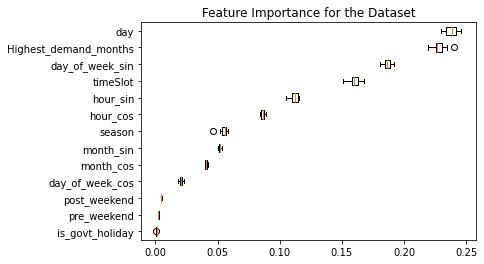

In [58]:
# Permuation importance of features 
result = permutation_importance(lgbm, X.values, y, n_repeats=10, random_state=42)

perm_imp_idx = result.importances_mean.argsort()

plt.boxplot(result.importances[perm_imp_idx].T, vert=False, labels=X.columns[perm_imp_idx])
plt.title('Feature Importance for the Dataset')

plt.show()

In [59]:
predicted_test = lgbm.predict(test[x_cols])
predicted_test

array([62.5796537 , 48.68331891, 48.68511086, ..., 62.02486743,
       59.75967421, 58.74137258])

In [60]:
test['demand'] = predicted_test

In [61]:
test.head()

,date,hour,month,day,weekofyear,day_of_week,is_weekend,post_weekend,pre_weekend,quarter,...,timeSlot,Highest_demand_months,season,hour_sin,hour_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos,demand
0,2021-03-01,0,3,1,9,0,0,0,0,1,...,2,0,2,0.000000,1.000000,1.0,6.123234e-17,0.0,1.0,62.579654
1,2021-03-01,1,3,1,9,0,0,0,0,1,...,5,0,2,0.258819,0.965926,1.0,6.123234e-17,0.0,1.0,48.683319
2,2021-03-01,2,3,1,9,0,0,0,0,1,...,5,0,2,0.500000,0.866025,1.0,6.123234e-17,0.0,1.0,48.685111
3,2021-03-01,3,3,1,9,0,0,0,0,1,...,5,0,2,0.707107,0.707107,1.0,6.123234e-17,0.0,1.0,48.800667
4,2021-03-01,5,3,1,9,0,0,0,0,1,...,4,0,2,0.965926,0.258819,1.0,6.123234e-17,0.0,1.0,45.624336


In [62]:
test[['date', 'hour', 'demand']].head()

,date,hour,demand
0,2021-03-01,0,62.579654
1,2021-03-01,1,48.683319
2,2021-03-01,2,48.685111
3,2021-03-01,3,48.800667
4,2021-03-01,5,45.624336


In [63]:
# Save the submission
test[['date', 'hour', 'demand']].to_csv('lightgbm_submission.csv', index=False)